In [1]:
import numpy as np
import numpy.linalg as nplin
import scipy.linalg as cplin
import scipy.optimize as opt
import time
#Load data 
problem=1;
A=np.load("P"+str(problem)+"A.npy");
b=np.load("P"+str(problem)+"b.npy");
c=np.load("P"+str(problem)+"c.npy");
AT=np.transpose(A)
#Set parameters
mu=1; gamma=0.7; eps_mu=1e-4; 
#Set initial guess x_0/s_0
m1=10; m2=10; M=m1+m2; N=2;
m=[m1,m2]
x_0=np.zeros([M*(M+1),1]);
x_0[:m1*M]=1/m1/M
x_0[m1*M:(m1+m2)*M]=1/m2/M
x_0[-M:]=1/M;
y_0=np.zeros([(N+1)*M+1-N,1]);
y_0[:M]=-1;y_0[-1]=-1;
s_0=c-np.matmul(AT,y_0)

def stepsize(x,s,dx,ds,eta=0.9995):
    alphax = -1/np.min(np.min(np.divide(dx,x)),-1); alphax = min(1, eta * alphax);
    alphas = -1/np.min(np.min(np.divide(ds,s)),-1); alphas = min(1, eta * alphas);
    return (alphax,alphas)

qs=np.load("P1q.npy",allow_pickle=True)
q1=qs[0]
q2=qs[1]



In [2]:
max_ite=50;
count=0;
eps=1e-4;
first_few_ite=5;
supp=M;
q=np.zeros([M,1])
tm=time.time()
for k in range(first_few_ite):
    #Fix support, solve for Pi and w
    x=np.array(x_0);
    p=np.array(y_0);
    s=np.array(c-np.matmul(AT,p));
    while (np.mean(np.multiply(x,s))>eps and count<max_ite):
        rp = np.matmul(A,x)-b;
        rd = np.matmul(AT,p)+s-c;
        rc = np.multiply(x,s);
        mu = np.mean(rc);
        print(mu)
    ## ----- Predictor step -----
        D2 = np.diag(np.divide(x,s)[:,0]);
        t1 = np.multiply(x,rd)-rc;  
        t2 = -(rp+np.matmul(A,np.divide(t1,s))); 
        AD2A=np.matmul(A,np.matmul(D2,AT))
        dp=nplin.solve(AD2A,t2)  
        dx = np.divide((np.multiply(np.matmul(AT,dp),x)+t1),s);
        ds = -np.divide((np.multiply(s,dx)+rc),x);
        eta = max(0.95,1-mu);   
        alphax = -1/np.min(np.min(np.divide(dx,x)),-1);
        alphas = -1/np.min(np.min(np.divide(ds,s)),-1);
        mu_aff = np.mean(np.multiply(x+alphax*dx,s+alphas*ds));
        sigma = (mu_aff/mu)**3;    
    ## ----- Corrector step -----
        rc = rc+np.multiply(dx,ds)-sigma*mu;
        t1 = np.multiply(x,rd)-rc; 
        t2 = -(rp+np.matmul(A,np.divide(t1,s))); 
        dp=nplin.solve(AD2A,t2) 
        dx = np.divide((np.multiply(np.matmul(AT,dp),x)+t1),s);
        ds = -np.divide((np.multiply(s,dx)+rc),x);
        alphax, alphas = stepsize(x, s, dx, ds, eta);
        x = x + alphax * dx;
        s = s + alphas * ds;
        p = p + alphas * dp;   
          
    #Fix Pi and w, solve for support and update 
    if (k==first_few_ite-1):
        mu = np.mean(np.multiply(x,s));
        print(mu)
        break;
    for i in range(M):
        sum1=0;
        sum2=0;
        #t=1
        for j in range(m1):
            sum1+=x[j*M+i]
            sum2+=x[j*M+i]*q1[j]
        #t=2
        for j in range(m2):
            sum1+=x[m1*M+j*M+i]
            sum2+=x[m1*M+j*M+i]*q2[j]
        q[i]=sum2/sum1
    d1=[]
    for i in range(m1):
        for j in range(M):
            d1.append((q1[i]-q[j])**2)
    d1=np.array(d1)
    d2=[]
    for i in range(m2):
        for j in range(M):
            d2.append((q2[i]-q[j])**2)
    d2=np.array(d2)
    c=np.concatenate([d1,d2,np.zeros([M,1])])
    print(k)
#Primal Step
for iter in range(60):
    D = np.diag(np.multiply(x,x)[:,0])
    t2 = np.matmul(A,np.multiply(x,np.multiply(x,c)-mu));
    AD=np.matmul(A,D)
    ADAT=np.matmul(AD,AT)
    y=nplin.solve(ADAT,t2)
    dp = x + (np.matmul(D,np.matmul(AT,y)-c))/mu;
    #dp(ind) = dp(ind) - A_cor\(A_true*dp);
    alpha = np.min([-0.99/np.min(np.divide(dp,x)),1]);
    x = x+alpha*dp;
    mu = mu*gamma;
    #update support
    for i in range(M):
        sum1=0;
        sum2=0;
            #t=1
        for j in range(m1):
            sum1+=x[j*M+i]
            sum2+=x[j*M+i]*q1[j]
            #t=2
        for j in range(m2):
            sum1+=x[m1*M+j*M+i]
            sum2+=x[m1*M+j*M+i]*q2[j]
        q[i]=sum2/sum1
    d1=[]
    for i in range(m1):
        for j in range(M):
            d1.append((q1[i]-q[j])**2)
    d1=np.array(d1)
    d2=[]
    for i in range(m2):
        for j in range(M):
            d2.append((q2[i]-q[j])**2)
    d2=np.array(d2)
    c_new=np.concatenate([d1,d2,np.zeros([M,1])])
    change_c = nplin.norm(c_new-c)/(nplin.norm(c_new)+nplin.norm(c)+1);
    newval=np.sum(np.multiply(x,c_new))
    oldval=np.sum(np.multiply(x,c))
    change_val = (oldval-newval)/(1+newval+oldval)
    c=c_new
    print(iter)
    print(newval)
    print(change_val)
    print(change_c)
print(time.time()-tm)

0.010229155708038593
0.0023075858660583847
0.0009084687663717495
0.00047111094146209015
0.00031671331999923803
0
0.00899490675503012
0.0022584133844378656
0.0012362506742182432
0.00022569162125488538
1
0.008968317432410682
0.0023074950263493486
0.0012286181122096258
0.00029444937998471656
2
0.008954667695146594
0.002340503904529301
0.0011331632351579458
0.0003257320570312863
0.00011045171149607772
3
0.008992955439191697
0.0023181532499982984
0.0010110513745142434
0.00026689198784033525
8.468304506014277e-05
0
0.5252238184682735
0.0004943959765321876
0.024991404468922732
1
0.5214258465646774
2.9858902816431875e-05
0.006042725041967654
2
0.5158862828346455
0.00012733449911101426
0.01348165873990097
3
0.5133072450207605
0.00018519488493112617
0.031726461086475595
4
0.51059923203161
3.066876018097969e-05
0.005609333452348129
5
0.5069467032505919
4.488115388662039e-05
0.006856710624424344
6
0.5068492436677632
1.197185943812e-05
0.006917310626648852
7
0.5056386940908595
2.1746401425432162e-0

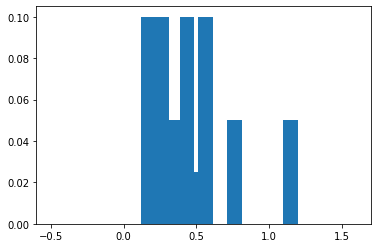

In [12]:

import matplotlib.pyplot as plt

plt.bar(q[:,0],x[-M:,0],width=0.1)
plt.xlim([-0.6,1.7])
plt.savefig("P1_MAAIPM")

In [10]:
q[:,0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])